## Predicting Insurance Claims for Porto Seguro

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

**Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies**, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

_____

### Breaking it down...

Basically, PS (Porta Seguro) wants to calculate their budgeting using a scientific backbone, primarily through the use of machine learning! It's simple, if they know how many insurance claims will be made for each driver, they'll get an estimate on how much they'll need to pay out. Knowing this, they can up the predmiums for the bad drivers, and lower the premium for the good, essentially leveling out the costs associated in the coming year. Doing this, they are maximizing the probabilty that good drivers will respond positively to the premium changes, which in turn obviously helps the company stay in business.

Let's start by preprocessing the data and getting it prepped for training.

### Preprocess data

Note the Label Name System:

Types - ind, reg, car, calc
BIN - binaray
CAT - categorical
NONE - cont or ordinal
Target - POS class = filed claim
VALUES of '-1' indicate missing


Let's beging by importing our dependencies, and then reading in train and test sets.

In [72]:
# Import the good stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adspy_shared_utilities import plot_labelled_scatter, plot_feature_importances

from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
# Read in data
def ReadData():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    return train, test

# Read in data
df_train, df_test = ReadData()

Let's drop some features we absoultely do not need for analysis. This would simply include features that have a majority of nan's. We can do this by running the self-defined MajorityNaN function.

To note, we'd like to remove features during this step that may appear redundant, but the column names provided are purposefully abstract. We can remove features later, however, once we've finished with some manual preprocessing by using a meta transformer such as SelectFromModel. Feature selection/removal for this data set is extremely important, as the size of the data is quite large.

In [4]:
# Drop features that have majority NaN
# Replace -1 with np.NaN
df_train.replace(-1, np.nan, inplace = True)
df_test.replace(-1, np.nan, inplace = True)

# NaN majority check
def MajorityNaN(df):
    majority = 0.5
    this = (df.isnull().sum() / len(df)) <= majority # Bool the majority
    print("Found to have majority NaN: ")
    print(this[this==False].index.tolist()) # Print what got removed
    df = df.loc[:, this] # update df
    return df

df_train = MajorityNaN(df_train)
df_test = MajorityNaN(df_test)

Found to have majority NaN: 
['ps_car_03_cat']
Found to have majority NaN: 
['ps_car_03_cat']


Next, we'll fill the NaN's with both the mean and frequency of the respected feature. Alternatively, we could impute the data with some of the built in modules from Sci-kit learn, but we'll manually add these in ourselves.

Afterwards, we'll one-hot-encode with a self-defined function to remove the categorical data and replace them with binary codes. A frequency threshold is set that dumps categories that are below this threshold into an 'unknown' category. We'll also ensure that the number of categories remains consistent with our test set.

In [5]:
# Let's first write a function to call each feature by its respected 'type'. 
# This will make it easier to fill nan's and one-hot-encode.

# Requires input dataframe and labeltype ['cat', 'bin', or 'other']
def GetFeatures(df, labelType):
    if labelType == 'other':
        label_type_bool = (~df.columns.str.contains('cat')) & (~df.columns.str.contains('bin'))
        features = df.columns[label_type_bool]
    else:
        label_type_bool = df.columns.str.contains(labelType)
        features = df.columns[label_type_bool]
        
    return features.tolist()

features_type = GetFeatures(df_train, 'cat')

# Fill NaN's
def fillNa(df):
    # other (not cat or bin) replaced with mean
    features_type = GetFeatures(df, 'other')
    df[features_type] = df[features_type].fillna(df[features_type].mean())
    
    # cat replaced with most frequent per feature
    features_type = GetFeatures(df, 'cat')
    for feature in features_type:
        df[feature] = df[feature].fillna(df[feature].value_counts().index[0])

    return df

df_train = fillNa(df_train)
df_test = fillNa(df_test)


def OneHotEncode(train, test, features):
    threshold = 100 # frequency of categories
    unknown_cat = '<unknown>' # name of additional 'unknown' category
    
    for feature in features:
        # Get count and cats to keep from train (so it matches test)
        count = train[feature].value_counts()
        categories_to_keep = count[count > threshold].index.tolist()  
         
        # Set each feature as cats with cats to keep above
        train[feature] = pd.Categorical(train[feature], 
                categories = categories_to_keep, ordered=True)
        
        if unknown_cat in categories_to_keep:
            categories_to_keep.remove(unknown_cat)
        test[feature] = pd.Categorical(test[feature], 
                categories = categories_to_keep, ordered=True)
        
        # Add unknown cat based on train features, then just fill in na's for both
        train[feature] = train[feature].cat.add_categories(unknown_cat).fillna(unknown_cat) 
        test[feature] = test[feature].cat.add_categories(unknown_cat).fillna(unknown_cat)
        
    # get_dummies
    train = pd.get_dummies(train, columns = features)
    test = pd.get_dummies(test, columns = features)
    
    return train, test

df_train_og, df_test_og = df_train.copy(), df_test.copy()
df_train, df_test = OneHotEncode(df_train, df_test, features_type)

### Train the Model

We can now train the model with any classifer, as we have successfully removed all categorical data. Note that we could have left the categorical data, but that would limit us to using specific classifiers like decision trees to train our model, which can be expensive given the data size. It's best we start simple with a low-level classifier to get quick results. From there, we can expand and build if we believe the time and effort is worth the improvement in score.

Let's define some helpful functions for us as we begin to train the model.

In [27]:
# GridSearch function
def runGridCV(alg, train, param_grid, features):
    print('Running gridsearchcv...')
    cv = StratifiedKFold(n_splits = 5, random_state = 0)
    gsearch = GridSearchCV(alg, param_grid = param_grid, 
                            scoring='roc_auc', cv = cv)
    gsearch.fit(train[features],train[target])
    print('Done!')
    return gsearch

# CV: Time Series or group wise? 
#http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-i-i-d-data
def runCV(alg, train, scoring, cv, features):
    print('Running CV...')
    scores = cross_validate(alg, train[features], train[target], 
                            scoring=scoring, cv = cv)
    print('Done!')
    return scores
    
# If train/validation metrics look okay, proceed with test proba                  
def runTest(train, test, estimator):
    estimator.fit(train[predictors], train[target])
    y_prob = estimator.predict_proba(test[predictors])[:,1]
    df = pd.DataFrame(y_prob, columns=['target']).join(test[ID]).set_index('id')
    df.to_csv('submit.csv')
    
#Generate a simple plot of the test and training learning curve.
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring = 'roc_auc',
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    print("Plotting learning curve...")

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("roc_auc Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring, random_state=0)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    print("Done!")
    return plt



#### Logistic Regression

We can start with a simple yet powerful logistic regression classifier. Note that we'll have to transform the data in order to use logistic regresion. Not transforming the data will add weight to other features that may not actually hold more significance over another. For this, we'll use pipelining. 

Let's define our 'predictors', 'target' and 'id' column just to cherry-pick these out quickly.

In [16]:
ID = 'id'
target = 'target'
predictors = [x for x in df_train.columns if x not in [ID, target]]
predictors_og = [x for x in df_train_og.columns if x not in [ID, target]]

Let's run our first classifier and see the result on our train and validation set (5 folds). Note that we will score this with roc_auc as we care about maximizing TP and reducing FP. A simple accuracy score will not suffice.

In [8]:
# Run CV
cv = StratifiedKFold(n_splits = 5, random_state = 0)
estimator = LogisticRegression(C = 1.0, random_state = 0)
clf = make_pipeline(MinMaxScaler(), estimator)

In [35]:
scores = runCV(clf, df_train, 'roc_auc', cv, predictors)

Running CV...
Done!


In [36]:
scores

{'fit_time': array([ 15.33459902,  15.11165786,  14.86867118,  15.39089465,  14.73473787]),
 'score_time': array([ 0.36393046,  0.36361003,  0.37108636,  0.36432528,  0.35638642]),
 'test_score': array([ 0.6271669 ,  0.62472212,  0.62694798,  0.62786436,  0.62367222]),
 'train_score': array([ 0.63236249,  0.63314914,  0.63255222,  0.6323056 ,  0.63338279])}

In [37]:
scores['train_score'].mean()

0.63275044694834937

In [38]:
scores['test_score'].mean()

0.62607471809014181

We can note above that our train and test scores are pretty close, and actually quite low. This is clearly a biased model, and thus needs more complexity. Let's try increasing our C parameter (inverse of our regularization constant, lambda) over a gridsearch.

In [39]:
# Call GridSearch function
pipe = Pipeline(steps = [('scaler', MinMaxScaler()), ('logistic', estimator)])

# Prediction
C = np.arange(1, 11, 1).tolist()

# Parameters of pipelines can be set using ‘__’ separated parameter names:
clf_g_1 = GridSearchCV(pipe, dict(logistic__C = C), scoring='roc_auc', cv = cv)
clf_g_1.fit(df_train[predictors],df_train[target])

clf_g_1.best_score_, clf_g_1.best_params_ 

(0.62607472315614288, {'logistic__C': 1})

From the above test score, we can see that the score doesn't change much at all from the defaul model. The parameter C stays at 1. We can conclude that Logistic Regression is probably too simple of a model, and that there is some bias (underfitting) going on that we cannot fix by simply tuning the parameters. Let's plot a learning curve of the train / validation set and confirm our suspicion. 

We'll use a cv value of 2 to improve the time, as there is really no point in running 5 folds for such an early estimte of our model.

Plotting learning curve...


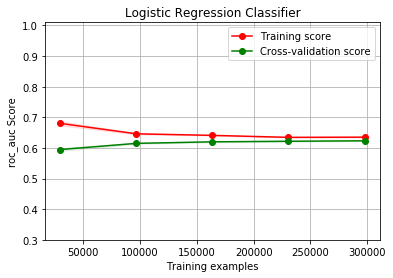

In [45]:
title = "Logistic Regression Classifier"
plot_learning_curve(estimator, title, df_train[predictors], df_train[target], 
                   ylim = (0.3, 1.01), cv = 2)
plt.show()

As we predicted, this model is severaly underfitting the data. The training score and validation score converge at about 240,000 samples (or a total of 480,000 samples).

So, we know we'll need a more robust model to tackle this data set. *However, a more robust is not gaurenteed to fix our underlying high bias issue* - we may need to **engineer new features** to add variance into this dataset.

### Gradient Boosted Decision Trees

We can use a more robust model, namely a Gradient Boosted Decision Tree (GBDT), to train our model. This classifier is a great 'off-the-shelf' solution for many problems with high dimensionality, and continuous, categorical and binary data. With that, let's use our training set without the one-hot-encoded features (predictors_og), and produce the results. 

Note: With GBDT, there is no need to normalize/scale the data, thus we will not run a pipline with the estimator and scaler functions.

In [23]:
cv = StratifiedKFold(n_splits = 5, random_state = 0)
clf_GBC = GradientBoostingClassifier(random_state = 0)

In [26]:
scores = runCV(clf_GBC, df_train_og, 'roc_auc', cv, predictors_og)

Running CV...
Done!


In [31]:
print("Train score: {}. Test score: {}".format(scores['train_score'].mean(), scores['test_score'].mean()))

Train score: 0.6484083007753838. Test score: 0.6366233275137823


We can see that the train/test scores from GBDT out-perform the scores from the logistic regression model. However, the model is still highly biased. 

We can correct the underfitting by engineering new features, but the feature names are inherently abstract (this was Porto Seguro's intention) and thus we cannot engineer by just using off feature names. 

Another approach is to find the most important features (important meaning a feature that holds the most weight in predicting correctly) and then engineer features basesd on those features. We can plot the feature importances from GBDT, as shown below:

In [35]:
clf_GBC.fit(df_train_og[predictors_og],df_train[target])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

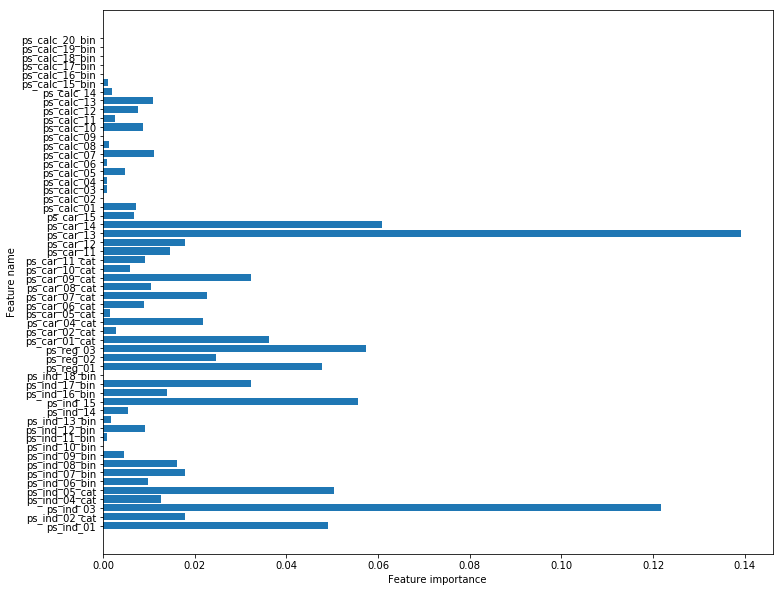

In [45]:
plt.figure(figsize=(12, 10))
plot_feature_importances(clf_GBC, predictors_og)
plt.show()

From the plot above, we can hand-pick the two largest contributers:

    'ps_car_13'
    'ps_ind_03'

We could now perform some type of engineering on these features, like creating polynomial features of degree 'n' or performing some operation between the two, though we'd be careful to not add redundant data. 

We could plot these two features against the target value, but let's take a peek at the unique values of the feature 'ps_ind_03'.


In [78]:
df_train_og.ps_ind_03.unique()

array([ 5,  7,  9,  2,  0,  4,  3,  1, 11,  6,  8, 10], dtype=int64)

This looks a **lot like categorical data, and not continuous** (as it was defined). A scatter plot will be pretty meaningless here. Let's look at a violin plot of the two features. 

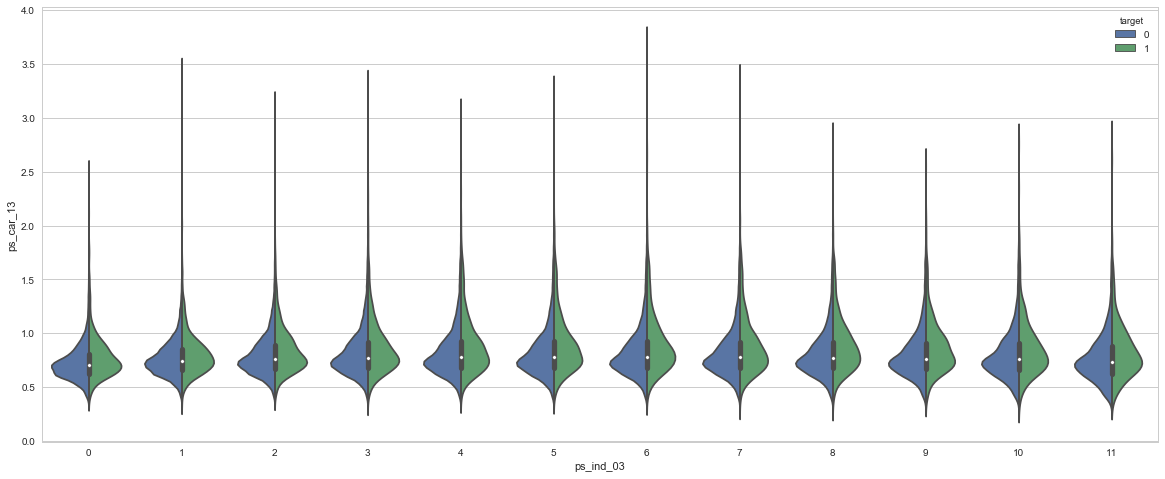

In [77]:
plt.figure(figsize=(20,8))
sns.set(style="whitegrid", color_codes=True)
sns.violinplot(x="ps_ind_03", y="ps_car_13", hue="target", data=df_train_og, split=True)
plt.show()

Looking at this violin plot, we can see how the categorical data is distributed across the opposing continous feature, with a 'hue' of the target value. It appears that the target value is pretty well distributed across all the categories. We expected that there would be more representation of the negative class (0), as the data is quite skewed (approx. 4% positive). 

Outliers between these two features is pretty standard, with the majority of categories found within 0.5 and 1.0 of ps_car_13.

## Feature Engineering

Lorem Ipsum Lorem Ipsum Lorem Ipsum Lorem Ipsum Lorem Ipsum Lorem Ipsum 
Lorem Ipsum Lorem Ipsum Lorem Ipsum Lorem Ipsum Lorem Ipsum Lorem Ipsum 

### Visualizing The Data

Using dimensionality reduction, we can see what the 200+ features look like on 2d scale. 

For our first plot, we'll use the popular t-PCA dimensional scaling function. Note that we'll have to transform the data to have zero mean and unit (1) variance. Using StandardScaler...

### PCA

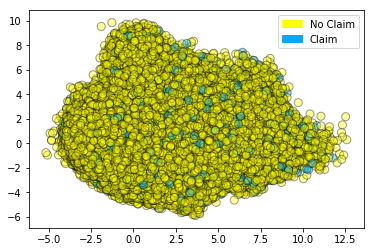

In [28]:
X_normalized = StandardScaler().fit(df_train[predictors]).transform(df_train[predictors])  

pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

plot_labelled_scatter(X_pca, df_train[target], ['No Claim','Claim'])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Insurance Claim PS Dataset PCA (n_components = 2)');
plt.show()

From the above results, it's hard to discern any sort of grouping between drivers who filed a claim, and those who did not. We can perform further dimensionality reductions like t-SNE and MDS, and even do some clustering work like KMeans (categorical data is supported with other KMeans algorithms) and DBSCAN.